In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Определяем трансформации для предобработки данных
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Задаем путь к папке с данными
data_dir = 'dataset_new_di'

# Загружаем данные
full_data = datasets.ImageFolder(root=data_dir, transform=transform)

# Разделяем данные на обучающие и валидационные
train_size = int(0.8 * len(full_data))
valid_size = len(full_data) - train_size
train_data, valid_data = random_split(full_data, [train_size, valid_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)

# Количество классов
num_classes = len(full_data.classes)


In [3]:
num_classes

10

In [4]:
full_data.classes

['кроссовки',
 'ноутбук',
 'планшет',
 'платье',
 'смартфон',
 'стол',
 'стул',
 'телевизор',
 'туфли',
 'чехол для телефона']

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [8]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    best_valid_accuracy = 0.0
    best_model_path = 'best_model.h5'
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_valid_loss = 0.0
        corrects = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_valid_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                corrects += torch.sum(preds == labels.data)
        
        epoch_valid_loss = running_valid_loss / len(valid_loader.dataset)
        epoch_valid_accuracy = corrects.double() / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)

        # сохраняем результаты модели с лучшей точностью
        if epoch_valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = epoch_valid_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved the best model with accuracy: {best_valid_accuracy:.4f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {epoch_valid_accuracy:.4f}")

    return train_losses, valid_losses, valid_accuracies

In [9]:
def plot_metrics(train_losses, valid_losses, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Train Loss')
    plt.plot(epochs, valid_losses, 'r', label='Valid Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, 'g', label='Valid Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=full_data.classes, columns=full_data.classes)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=full_data.classes, yticklabels=full_data.classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [11]:
# Обучаем модель
train_losses, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=25)

Saved the best model with accuracy: 0.3278
Epoch 1/25, Train Loss: 2.0728, Valid Loss: 1.8696, Valid Accuracy: 0.3278
Saved the best model with accuracy: 0.5282
Epoch 2/25, Train Loss: 1.5604, Valid Loss: 1.3667, Valid Accuracy: 0.5282
Saved the best model with accuracy: 0.6158
Epoch 3/25, Train Loss: 1.1661, Valid Loss: 1.1666, Valid Accuracy: 0.6158
Saved the best model with accuracy: 0.6415
Epoch 4/25, Train Loss: 0.8049, Valid Loss: 1.0991, Valid Accuracy: 0.6415
Saved the best model with accuracy: 0.6511
Epoch 5/25, Train Loss: 0.5292, Valid Loss: 1.1770, Valid Accuracy: 0.6511
Saved the best model with accuracy: 0.6722
Epoch 6/25, Train Loss: 0.3636, Valid Loss: 1.1954, Valid Accuracy: 0.6722
Saved the best model with accuracy: 0.6788
Epoch 7/25, Train Loss: 0.2654, Valid Loss: 1.4135, Valid Accuracy: 0.6788
Epoch 8/25, Train Loss: 0.2025, Valid Loss: 1.4019, Valid Accuracy: 0.6767
Epoch 9/25, Train Loss: 0.1756, Valid Loss: 1.4870, Valid Accuracy: 0.6788
Saved the best model wit

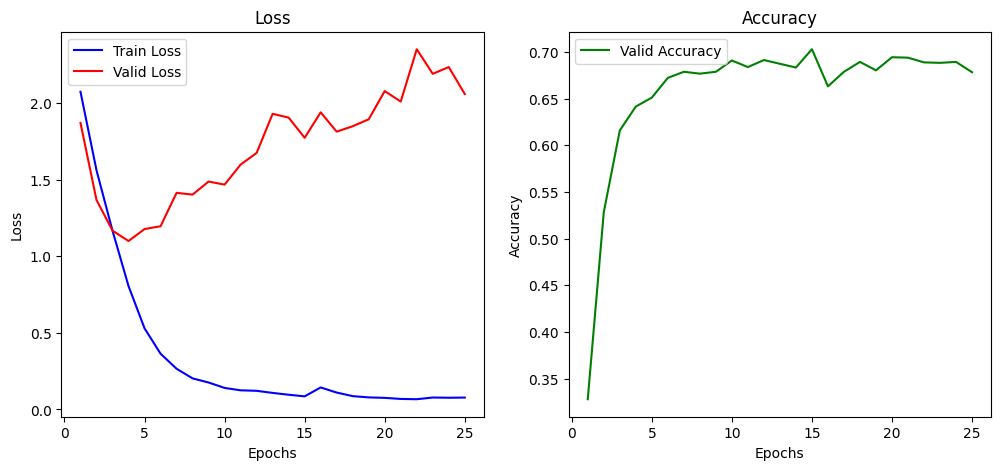

In [26]:
# Построение графиков
plot_metrics(train_losses, valid_losses, valid_accuracies)

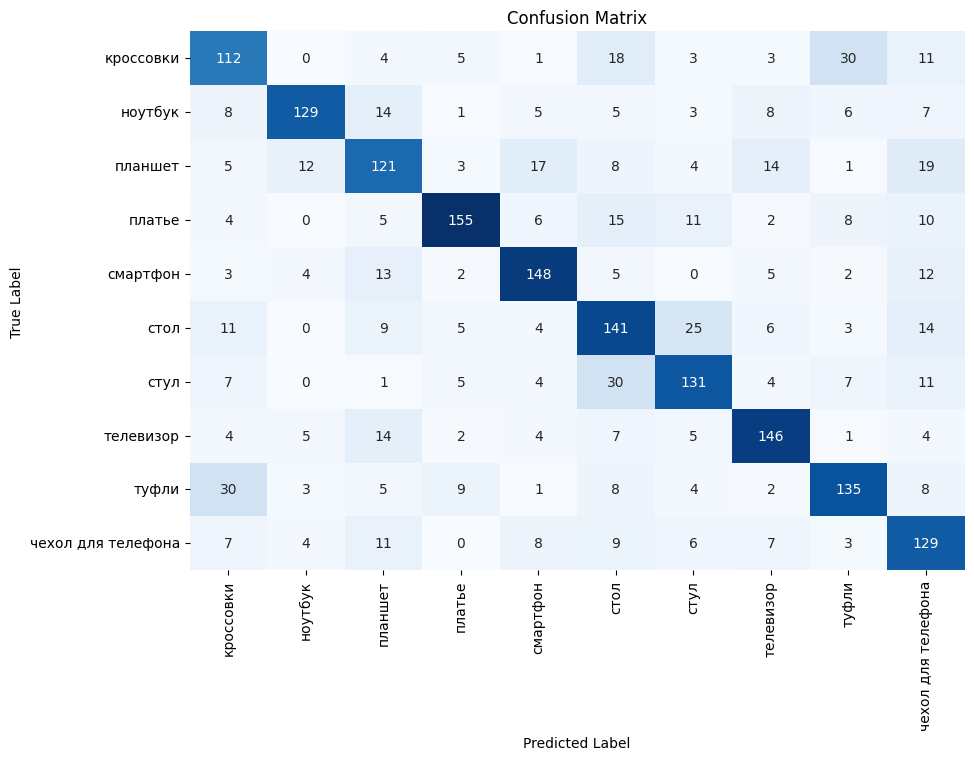

In [13]:
# Построение матрицы ошибок
plot_confusion_matrix(model, valid_loader)

In [41]:
from PIL import Image

def classify_image(model, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Трансформируем изображение
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        class_id = preds.item()
    
    return full_data.classes[class_id]

In [42]:
# Классификация нового изображения
image_path = 'dataset_new_di/ноутбук/769963030_image_2.jpg'
print(f'The image is classified as: {classify_image(model, image_path)}')

The image is classified as: ноутбук


In [58]:
import torch
import h5py

# Сохраните модель в формат .pth
torch.save(model.state_dict(), 'model.pth')

# Загрузите веса модели
state_dict = torch.load('model.pth')

# Создайте файл .h5 и сохраните веса в этом файле
with h5py.File('model.h5', 'w') as f:
    for key, value in state_dict.items():
        f.create_dataset(key, data=value.numpy())

/var/folders/p0/0pq571r52xb2y2591gck9lww0000gn/T/ipykernel_13990/3110061813.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model.pth')


In [ ]:
import torch
import h5py

# Загрузите веса из файла .h5
state_dict = {}
with h5py.File('model.h5', 'r') as f:
    for key in f.keys():
        state_dict[key] = torch.tensor(f[key][...])

# Создайте модель и загрузите в нее веса
model = SimpleCNN(num_classes)
model.load_state_dict(state_dict)


In [43]:
dataset_path = 'dataset_new_di'
subfolders = ['кроссовки', 'ноутбук', 'планшет', 'платье', 'смартфон', 'стол', 'стул', 'телевизор', 'туфли', 'чехол для телефона']
class_names = ['кроссовки', 'ноутбук', 'планшет', 'платье', 'смартфон', 'стол', 'стул', 'телевизор', 'туфли', 'чехол для телефона']

results = {}

for folder in subfolders:
    folder_path = os.path.join(dataset_path, folder)
    correct = 0
    incorrect = 0
    total = 0
    
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        if '.DS_Store' in image_path:
            pass
        else:
            predicted_label = classify_image(model, image_path)
            total += 1
            if predicted_label == folder:
                correct += 1
            else:
                incorrect += 1
    
    results[folder] = {
        'correct': correct,
        'incorrect': incorrect,
        'total': total
    }

In [56]:
for folder, result in results.items():
    print(f'Папка: {folder}')
    prcntg = (int(result["correct"]) / int(result["total"]) * 100)
    print(f"Правильно классифицировано: {prcntg:.2f}%\n")

Папка: кроссовки
Правильно классифицировано: 89.86%

Папка: ноутбук
Правильно классифицировано: 95.40%

Папка: планшет
Правильно классифицировано: 89.79%

Папка: платье
Правильно классифицировано: 95.20%

Папка: смартфон
Правильно классифицировано: 95.40%

Папка: стол
Правильно классифицировано: 91.20%

Папка: стул
Правильно классифицировано: 95.30%

Папка: телевизор
Правильно классифицировано: 95.70%

Папка: туфли
Правильно классифицировано: 94.40%

Папка: чехол для телефона
Правильно классифицировано: 92.50%



In [44]:
# Выводим результаты
for folder, result in results.items():
    print(f'Папка: {folder}')
    print(f'Правильно классифицировано: {result["correct"]}')
    print(f'Неправильно классифицировано: {result["incorrect"]}')
    print(f'Всего изображений: {result["total"]}\n')

Папка: кроссовки
Правильно классифицировано: 913
Неправильно классифицировано: 103
Всего изображений: 1016

Папка: ноутбук
Правильно классифицировано: 871
Неправильно классифицировано: 42
Всего изображений: 913

Папка: планшет
Правильно классифицировано: 897
Неправильно классифицировано: 102
Всего изображений: 999

Папка: платье
Правильно классифицировано: 951
Неправильно классифицировано: 48
Всего изображений: 999

Папка: смартфон
Правильно классифицировано: 953
Неправильно классифицировано: 46
Всего изображений: 999

Папка: стол
Правильно классифицировано: 912
Неправильно классифицировано: 88
Всего изображений: 1000

Папка: стул
Правильно классифицировано: 953
Неправильно классифицировано: 47
Всего изображений: 1000

Папка: телевизор
Правильно классифицировано: 957
Неправильно классифицировано: 43
Всего изображений: 1000

Папка: туфли
Правильно классифицировано: 944
Неправильно классифицировано: 56
Всего изображений: 1000

Папка: чехол для телефона
Правильно классифицировано: 925
Неп

In [59]:
torch.save(model, 'model_torch_save.pth')

In [60]:
model_torch = torch.load('model_torch_save.pth')

/var/folders/p0/0pq571r52xb2y2591gck9lww0000gn/T/ipykernel_13990/2593773378.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_torch = torch.load('model_torch_save.pt

In [61]:
image_path = 'dataset_new_di/ноутбук/769963030_image_2.jpg'
print(f'The image is classified as: {classify_image(model_torch, image_path)}')

The image is classified as: ноутбук


In [7]:
# def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
    
#     train_losses = []
#     valid_losses = []
#     valid_accuracies = []
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item() * inputs.size(0)
        
#         epoch_loss = running_loss / len(train_loader.dataset)
#         train_losses.append(epoch_loss)
        
#         model.eval()
#         running_loss = 0.0
#         corrects = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in valid_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 running_loss += loss.item() * inputs.size(0)
                
#                 _, preds = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 corrects += torch.sum(preds == labels.data)
        
#         epoch_loss = running_loss / len(valid_loader.dataset)
#         valid_losses.append(epoch_loss)
        
#         epoch_acc = corrects.double() / total
#         valid_accuracies.append(epoch_acc.item())
        
#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
#               f"Valid Loss: {valid_losses[-1]:.4f}, Valid Accuracy: {valid_accuracies[-1]:.4f}")
    
#     return train_losses, valid_losses, valid_accuracies

# train_losses, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer)

/Users/annapetrov/Desktop/ozon_хакатон/.venv/lib/python3.9/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
